In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import decode_image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np

In [2]:
class ConvICNN(nn.Module):
    def __init__(self, linear_layers=4, convex_layers=5, downscale=[(2048, 128), (128, 64), (64, 32), (32, 1)], beta=1e-6):
        super().__init__()
        self.beta = beta
        self.linear_layers = linear_layers
        self.convex_layers = convex_layers
        self.downscale = downscale

        # Linear block
        # Here we use either identity activation or average pooling
        self.conv_direct = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=False))
        self.conv_sqr = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=False))
        for i in range(linear_layers - 2):
            self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False))
            self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False))
        self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))
        self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))

        # Convexity-preserving layers
        self.convex_pre_act = nn.CELU()
        self.convex = nn.Sequential()
        for i in range(convex_layers):
            self.convex.append(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1))#, padding=1, offset=1))
            self.convex.append(nn.CELU())

        self.linear = nn.Sequential()
        for i in range(len(downscale) - 1):
            self.linear.append(nn.Linear(downscale[i][0], downscale[i][1]))
            self.linear.append(nn.CELU())
        self.linear.append(nn.Linear(downscale[-1][0], downscale[-1][1]))


    def forward(self, x):
        x_input = x
        linear = self.conv_direct(x)
        linear += torch.square(self.conv_sqr(x))
        out = self.convex(self.convex_pre_act(linear))
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        strong_convexity = (self.beta / 2) * torch.sum(torch.square(x.reshape(x.size(0), -1)), dim=1, keepdim=True)
        return out + strong_convexity

    def update_weights(self):
        for i in range(0, self.convex_layers):
            # each Conv2d
            self.convex[i*2].weight.data.clamp_(min=0)

        for i in range(0, len(self.downscale)):
            # each Linear
            self.linear[i*2].weight.data.clamp_(min=0)

    def gradient(self, x):
        """Compute gradient of the network w.r.t. input"""
        #if not x.requires_grad:
        #    x = x.clone().requires_grad_(True)
        y = self.forward(x)
        grad = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad#.detach()

In [3]:
class W2GNLoss:
    """
    Wasserstein-2 Generative Network Loss
    """
    def __init__(self, psi_theta, psi_omega, lambda_cycle=1.0, devices=['cuda'], compute_extra_reg=False):
        self.lambda_cycle = lambda_cycle
        self.devices = devices
        self.dev0 = devices[0]
        self.dev1 = devices[1] if len(devices) > 1 else devices[0]
        self.compute_extra_reg = compute_extra_reg

        # Initialize primal and dual potentials
        self.psi_theta = psi_theta.to(self.dev0)
        self.psi_omega = psi_omega.to(self.dev1)

    def theta_device(self):
        return self.dev0

    def omega_device(self):
        return self.dev1

    def to_theta(self, t: torch.Tensor):
        """
        Transfer tensor to psi_theta device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev0, non_blocking=True)
        else:
            return t

    def to_omega(self, t: torch.Tensor):
        """
        Transfer tensor to psi_omega device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev1, non_blocking=True)
        else:
            return t

    def compute_correlations(self, X, Y, grad_psi_omega):
        """
        Compute Monte-Carlo estimate of correlations
        L_Corr = (1/K) * [sum psi_theta(x) + sum(<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y)))]
        """
        batch_size = X.shape[0]

        # Term 1: E_P[psi_theta(x)]
        term1 = self.psi_theta(X).mean()

        # Term 2: E_Q[<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y))]
        # Compute gradient of conjugate potential

        # Inner product <grad_psi_omega(y), y>
        inner_prod = torch.sum(grad_psi_omega * self.to_omega(Y), dim=(1, 2, 3), keepdim=True)

        # Evaluate primal potential at gradient
        psi_at_grad = self.psi_theta(self.to_theta(grad_psi_omega))

        term2 = (self.to_theta(inner_prod) - psi_at_grad).mean()

        return term1 + term2 # THETA

    def compute_cycle_consistency(self, X, Y):
        """
        Compute cycle consistency regularization
        R_Y = E_Q[||grad_psi_theta(grad_psi_omega(y)) - y||^2] + E_Q[||grad_psi_omega(grad_psi_theta(x)) - x||^2]
        """
        # Forward: omega -> theta
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y))
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(grad_psi_omega))

        # Compute squared difference
        diff = grad_psi_theta - self.to_theta(Y).detach()
        cycle_loss_y = torch.mean(diff ** 2)

        # Same for X
        grad_psi_theta_x = self.psi_theta.gradient(self.to_theta(X))
        grad_psi_omega_x = self.psi_omega.gradient(self.to_omega(grad_psi_theta_x))

        diff_x = grad_psi_omega_x - self.to_omega(X).detach()
        
        cycle_loss_x = torch.mean(diff_x ** 2)
        cycle_loss = cycle_loss_y + self.to_theta(cycle_loss_x)
        
        return cycle_loss # THETA

    def compute_extra_R(self, X):
        """
        Compute extra regularization term
        R_X = (1/K) * [sum ||grad_psi_omega(grad_psi_theta(x)) - x||^2]
        """
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(grad_psi_theta))

        # Compute squared difference
        diff = grad_psi_omega - self.to_omega(X)
        r_reg = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))
        return r_reg # OMEGA

    def compute_reg(self):
        """
        Compute regularization of model params
        """
        reg_total = 0.0
        for p in self.psi_theta.parameters():
            reg_total += torch.sum(torch.abs(p))
        for p in self.psi_omega.parameters():
            reg_total += self.to_theta(torch.sum(torch.abs(p)))
        return reg_total

    def compute_loss(self, opt, X, Y):
        """
        Compute loss and calculate gradients. It is optimal to store X at device 0 and Y at device 1
        Args:
            opt: optimizer
            X: batch from source distribution P
            Y: batch from target distribution Q
        """
        X.requires_grad_(True)
        Y.requires_grad_(True)
        opt[0].zero_grad()
        opt[1].zero_grad()

        # Compute cycle consistency
        loss_cycle = self.compute_cycle_consistency(X, Y)

        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y))
        grad_psi_omega_d = grad_psi_omega.detach() # heuristic from Appendix C.1

        opt[0].zero_grad()
        opt[1].zero_grad()
        
        # Compute neg W dist & correlations
        loss_W = torch.mean(self.psi_theta(self.to_theta(X)) - self.psi_theta(self.to_theta(grad_psi_omega_d)))
        #with torch.no_grad():
        #    loss_W_const = (- (self.to_omega(X) ** 2).sum(dim=(1, 2, 3)) / 2).mean() + \
        #    ((grad_psi_omega_d * self.to_omega(Y)).sum(dim=(1, 2, 3)) - (self.to_omega(Y) ** 2).sum(dim=(1, 2, 3)) / 2).mean()
        #loss_corr = self.compute_correlations(X, Y, grad_psi_omega_d)

        # Total loss
        if self.compute_extra_reg:
            loss_R = 1e-10 * self.compute_reg() #self.to_theta(self.compute_extra_R(X))
            loss_R_item = loss_R.item()
            #loss_total = loss_corr + (self.lambda_cycle / 2) * loss_cycle + loss_R
            loss_total = loss_W + (self.lambda_cycle / 2) * loss_cycle + loss_R
        else:
            loss_R = None
            loss_R_item = None
            loss_total = loss_W + (self.lambda_cycle / 2) * loss_cycle

        # Gradient step
        loss_total.backward()
        opt[0].step()
        opt[1].step()
        opt[0].zero_grad()
        opt[1].zero_grad()

        return {
            'loss_corr': loss_W.item(),
            'loss_cycle': loss_cycle.item(),
            'loss_total': loss_total.item(),
            'loss_R': loss_R_item
        }

    def pretrain_loss(self, X):
        X.requires_grad_(True)
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        loss_mse = F.mse_loss(grad_psi_theta, X)
        loss_mse.backward()

        return loss_mse

    def apply_pretrain_weights(self):
        self.psi_omega.load_state_dict(self.psi_theta.state_dict())

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        return self.psi_theta.gradient(X).detach()

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        return self.psi_omega.gradient(Y).detach()

In [4]:
class W2GNTrainer:
    def __init__(self, loss_c, lr=1e-3, pre_lr=1e-3, betas_theta=(0.8, 0.99), betas_omega=(0.4, 0.4)):
        self.loss_c = loss_c
        self.optimizers = [
            torch.optim.Adam(
                list(self.loss_c.psi_theta.parameters()),
                lr=lr, betas=betas_theta
            ),
            torch.optim.Adam(
                list(self.loss_c.psi_omega.parameters()),
                lr=lr, betas=betas_omega
        )]

        self.preoptimizer = torch.optim.Adam(
           list(self.loss_c.psi_theta.parameters()),
           lr=pre_lr
        )

        self.history = {'loss_corr': [], 'loss_cycle': [], 'loss_total': [], 'loss_R': []}
        self.history_pre = []

    def step(self, X, Y):
        #self.optimizer.zero_grad()
        losses = self.loss_c.compute_loss(self.optimizers, X, Y)
        #self.optimizer.step()
        # Clamp weights in convexity-preserving layers to be non-negative
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()
            self.loss_c.psi_omega.update_weights()

        for x in losses.keys():
            if losses[x] is not None:
                self.history[x].append(losses[x])

        return losses

    def pretrain_step(self, X):
        self.preoptimizer.zero_grad()
        loss = self.loss_c.pretrain_loss(X)
        self.preoptimizer.step()
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()

        self.history_pre.append(loss)

        return loss

    def apply_pretrain(self):
        self.loss_c.apply_pretrain_weights()
        del self.preoptimizer

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        #with torch.no_grad():
        return self.loss_c.psi_theta.gradient(X)

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        #with torch.no_grad():
        return self.loss_c.psi_omega.gradient(Y)

In [5]:
class DiffusionNoiseSchedule:
    """Noise schedule for diffusion process"""
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        
    def add_noise(self, x, t):
        """Add noise to image at timestep t"""
        alpha_bar = self.alpha_bars[t].to(x.device)
        noise = torch.randn_like(x)
        noisy = torch.sqrt(alpha_bar) * x + torch.sqrt(1.0 - alpha_bar) * noise
        return noisy, noise
    
    def get_alpha_bar(self, t):
        return self.alpha_bars[t]


In [6]:
class DiffTrainer:
    """Diffusion model trainer using W2GN framework"""
    def __init__(self, loss_c, noise_schedule, lr=1e-3, betas_theta=(0.8, 0.99), betas_omega=(0.4, 0.4)):
        self.loss_c = loss_c
        self.noise_schedule = noise_schedule
        self.optimizers = [
            torch.optim.Adam(
                list(self.loss_c.psi_theta.parameters()),
                lr=lr, betas=betas_theta
            ),
            torch.optim.Adam(
                list(self.loss_c.psi_omega.parameters()),
                lr=lr, betas=betas_omega
            )
        ]
        
        self.history = {
            'loss_corr': [], 
            'loss_cycle': [], 
            'loss_total': [], 
            'loss_R': []
        }
    
    def step(self, clean_images, t_min=0, t_max=None):
        """
        Training step: denoise images
        Args:
            clean_images: batch of clean images (X)
            t_min: minimum timestep for noise
            t_max: maximum timestep for noise
        """
        if t_max is None:
            t_max = self.noise_schedule.timesteps - 1
            
        batch_size = clean_images.shape[0]
        
        # Sample random timesteps for each image in batch
        t = np.random.randint(t_min, t_max, size=batch_size)
        
        # Add noise to create Y (noisy images)
        noisy_images = []
        for i, img in enumerate(clean_images):
            noisy, _ = self.noise_schedule.add_noise(img.unsqueeze(0), t[i])
            noisy_images.append(noisy)
        noisy_images = torch.cat(noisy_images, dim=0)
        
        # X = clean images, Y = noisy images
        X = clean_images
        Y = noisy_images.to(self.loss_c.omega_device())
        
        # Training step
        losses = self.loss_c.compute_loss(self.optimizers, X, Y)
        
        # Update weights
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()
            self.loss_c.psi_omega.update_weights()
        
        # Record history
        for key in losses.keys():
            if losses[key] is not None:
                self.history[key].append(losses[key])
        
        return losses
    
    def denoise(self, noisy_image):
        """
        Denoise a single image
        Args:
            noisy_image: noisy input image
        Returns:
            denoised image
        """
        denoised = self.loss_c.inverse(noisy_image)
        return denoised
    
    def progressive_denoise(self, image, steps=10):
        """
        Progressive denoising from high noise to clean
        Args:
            image: input image
            steps: number of denoising steps
        Returns:
            list of progressively denoised images
        """
        results = [image]
        current = image
        
        timesteps = np.linspace(self.noise_schedule.timesteps-1, 0, steps).astype(int)
        
        for t in timesteps:
            # Add noise at level t
            noisy, _ = self.noise_schedule.add_noise(current, t)
            noisy.requires_grad_(True)
            # Denoise
            denoised = self.denoise(noisy).detach()
            results.append(denoised)
            current = denoised
            
        return results

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/summer2winter-yosemite")

In [8]:
class S2WDataset(torch.utils.data.Dataset):
    def __init__(self, root, target_shape, is_val=False):
        super().__init__()
        self.root = root
        self.target_shape = target_shape
        self.is_val = is_val

        self.trainA = "trainA"
        self.testA = "testA"
        self.trainB = "trainB"
        self.testB = "testB"

        if not is_val:
            #self.df = pd.read_csv(os.path.join(root, "metadata.csv"))
            self.imagesA = os.listdir(os.path.join(root, self.trainA))
            self.imagesB = os.listdir(os.path.join(root, self.trainB))
        else:
            self.imagesA = os.listdir(os.path.join(root, self.testA))
            self.imagesB = os.listdir(os.path.join(root, self.testB))

        self.transforms_A = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.CenterCrop(200),
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ColorJitter(0.025, 0.025, 0.025, 0.025),
            #transforms.ToTensor(),
            #transforms.Lambda(lambda x: x+torch.randn_like(x) * 0.01),
            #transforms.Lambda(lambda t: t.clamp(0,1)),
        ])
        self.transforms_B = self.transforms_A

        self.pics = min(len(self.imagesA), len(self.imagesB))

    def __len__(self):
        return self.pics

    def get(self, idx, pic_dirA, pic_dirB):
        img_pathA = os.path.join(self.root, pic_dirA, self.imagesA[idx])
        img_pathB = os.path.join(self.root, pic_dirB, self.imagesB[idx])

        # Load the image
        imgA = self.transforms_A(Image.open(img_pathA))#.resize((self.target_shape, self.target_shape))
        imgB = self.transforms_B(Image.open(img_pathB))#.resize((self.target_shape, self.target_shape))

        #return torch.stack([self.transforms_A(imgA), self.transforms_B(imgB)])#.permute(0, 3, 1, 2)

        out = torch.as_tensor(np.stack([
            np.asarray(imgA, dtype=np.float32), np.asarray(imgB, dtype=np.float32)
        ]) / 128.0 - 1.0).permute(0, 3, 1, 2)

        #out = out + torch.randn_like(out) * 0.01
        #out = out.clamp(0, 1)
        return out, {}

    @staticmethod
    def take(t, A: bool):
        if A:
            return t[:, 0]
        else:
            return t[:, 1]

    @staticmethod
    def to_image(t):
        t = t.clamp(-1, 1)
        return (t.permute(0, 2, 3, 1) + 1.0) * 128.0

    def get_train(self, idx):
        return self.get(idx, self.trainA, self.trainB)

    def get_val(self, idx):
        return self.get(idx, self.testA, self.testB)

    def __getitem__(self, idx):
        if self.is_val:
            return self.get_val(idx)
        return self.get_train(idx)

In [9]:
batch_size = 6
dataset = S2WDataset(path, 128)

datasetVal = S2WDataset(path, 128, is_val=True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

dataVal = torch.utils.data.DataLoader(
    datasetVal,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

In [10]:
psi_theta = ConvICNN()
psi_omega = ConvICNN()

In [11]:
loss_c = W2GNLoss(psi_theta, psi_omega, lambda_cycle=35000.0, compute_extra_reg=False, devices=["cuda:1"])
ns = DiffusionNoiseSchedule()
trainer = DiffTrainer(loss_c, ns, lr=1e-4)

In [25]:
# Main training loop
epochs = 30
for epoch in range(epochs):
    d_iter = iter(dataloader)

    for i in tqdm(range(len(dataloader)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        imgs = next(d_iter)[0]
        X = dataloader.dataset.take(imgs, A=True)
        #Y = dataloader.dataset.take(imgs, A=False)
        #print(X.shape, Y.shape)
        # Training step
        losses = trainer.step(X.to(trainer.loss_c.theta_device()), t_min=50, t_max=600)
        #losses = trainer.step(X.to(trainer.loss_c.theta_device()), Y.to(trainer.loss_c.omega_device()))

        loss_R = f"{losses['loss_R']:.4f}" if losses.get('loss_R') is not None else '?'
        print(f"\nEpoch {epoch}: " +
            f"W Dist={losses['loss_corr']:.4f}, " +
            f"Cycle={losses['loss_cycle']:.4f}, " +
            f"Reg={loss_R}, " +
            f"Total={losses['loss_total']:.4f}")

Epoch 1/30:   1%|▏                                   | 1/161 [00:01<03:20,  1.25s/it]


Epoch 0: W Dist=41.0861, Cycle=0.1046, Reg=?, Total=1871.7008


Epoch 1/30:   1%|▍                                   | 2/161 [00:02<03:07,  1.18s/it]


Epoch 0: W Dist=-2523.6924, Cycle=0.1523, Reg=?, Total=141.7874


Epoch 1/30:   2%|▋                                   | 3/161 [00:03<03:03,  1.16s/it]


Epoch 0: W Dist=191.8253, Cycle=0.1131, Reg=?, Total=2170.3770


Epoch 1/30:   2%|▉                                   | 4/161 [00:04<03:00,  1.15s/it]


Epoch 0: W Dist=-764.0537, Cycle=0.1152, Reg=?, Total=1252.4556


Epoch 1/30:   3%|█                                   | 5/161 [00:05<02:58,  1.14s/it]


Epoch 0: W Dist=-1441.8018, Cycle=0.1617, Reg=?, Total=1387.8733


Epoch 1/30:   4%|█▎                                  | 6/161 [00:06<02:56,  1.14s/it]


Epoch 0: W Dist=-53.2341, Cycle=0.1253, Reg=?, Total=2139.9419


Epoch 1/30:   4%|█▌                                  | 7/161 [00:08<02:55,  1.14s/it]


Epoch 0: W Dist=-142.3576, Cycle=0.1250, Reg=?, Total=2044.4236


Epoch 1/30:   5%|█▊                                  | 8/161 [00:09<02:54,  1.14s/it]


Epoch 0: W Dist=469.1227, Cycle=0.1494, Reg=?, Total=3083.5881


Epoch 1/30:   6%|██                                  | 9/161 [00:10<02:52,  1.14s/it]


Epoch 0: W Dist=-1333.6577, Cycle=0.1429, Reg=?, Total=1167.5789


Epoch 1/30:   6%|██▏                                | 10/161 [00:11<02:51,  1.14s/it]


Epoch 0: W Dist=-3225.2644, Cycle=0.1414, Reg=?, Total=-751.5298


Epoch 1/30:   7%|██▍                                | 11/161 [00:12<02:50,  1.14s/it]


Epoch 0: W Dist=-1725.8484, Cycle=0.1169, Reg=?, Total=320.2518


Epoch 1/30:   7%|██▌                                | 12/161 [00:13<02:49,  1.14s/it]


Epoch 0: W Dist=-1246.1316, Cycle=0.1482, Reg=?, Total=1347.6089


Epoch 1/30:   8%|██▊                                | 13/161 [00:14<02:47,  1.13s/it]


Epoch 0: W Dist=-579.6796, Cycle=0.1085, Reg=?, Total=1319.5059


Epoch 1/30:   9%|███                                | 14/161 [00:16<02:46,  1.14s/it]


Epoch 0: W Dist=-1607.8301, Cycle=0.1170, Reg=?, Total=439.4553


Epoch 1/30:   9%|███▎                               | 15/161 [00:17<02:45,  1.14s/it]


Epoch 0: W Dist=-501.7111, Cycle=0.1359, Reg=?, Total=1876.0681


Epoch 1/30:  10%|███▍                               | 16/161 [00:18<02:45,  1.14s/it]


Epoch 0: W Dist=1025.2484, Cycle=0.1348, Reg=?, Total=3384.2383


Epoch 1/30:  11%|███▋                               | 17/161 [00:19<02:43,  1.14s/it]


Epoch 0: W Dist=-69.3622, Cycle=0.1325, Reg=?, Total=2249.2290


Epoch 1/30:  11%|███▉                               | 18/161 [00:20<02:42,  1.14s/it]


Epoch 0: W Dist=-3570.8408, Cycle=0.1244, Reg=?, Total=-1393.2656


Epoch 1/30:  12%|████▏                              | 19/161 [00:21<02:41,  1.14s/it]


Epoch 0: W Dist=-55.0803, Cycle=0.1612, Reg=?, Total=2766.5349


Epoch 1/30:  12%|████▎                              | 20/161 [00:22<02:40,  1.14s/it]


Epoch 0: W Dist=-41.4164, Cycle=0.1633, Reg=?, Total=2816.3989


Epoch 1/30:  13%|████▌                              | 21/161 [00:23<02:39,  1.14s/it]


Epoch 0: W Dist=-1434.6555, Cycle=0.1341, Reg=?, Total=912.1704


Epoch 1/30:  14%|████▊                              | 22/161 [00:25<02:38,  1.14s/it]


Epoch 0: W Dist=-1840.5095, Cycle=0.1483, Reg=?, Total=753.9038


Epoch 1/30:  14%|█████                              | 23/161 [00:26<02:37,  1.14s/it]


Epoch 0: W Dist=1353.9271, Cycle=0.1119, Reg=?, Total=3312.6035


Epoch 1/30:  15%|█████▏                             | 24/161 [00:27<02:36,  1.14s/it]


Epoch 0: W Dist=-293.0916, Cycle=0.1292, Reg=?, Total=1968.7336


Epoch 1/30:  16%|█████▍                             | 25/161 [00:28<02:35,  1.14s/it]


Epoch 0: W Dist=-1804.6628, Cycle=0.1240, Reg=?, Total=365.8186


Epoch 1/30:  16%|█████▋                             | 26/161 [00:29<02:34,  1.14s/it]


Epoch 0: W Dist=2401.0623, Cycle=0.1471, Reg=?, Total=4975.5996


Epoch 1/30:  17%|█████▊                             | 27/161 [00:30<02:33,  1.14s/it]


Epoch 0: W Dist=819.2172, Cycle=0.1517, Reg=?, Total=3474.4453


Epoch 1/30:  17%|██████                             | 28/161 [00:31<02:32,  1.14s/it]


Epoch 0: W Dist=91.6917, Cycle=0.1167, Reg=?, Total=2133.2363


Epoch 1/30:  18%|██████▎                            | 29/161 [00:33<02:30,  1.14s/it]


Epoch 0: W Dist=-1357.7307, Cycle=0.1103, Reg=?, Total=573.1123


Epoch 1/30:  19%|██████▌                            | 30/161 [00:34<02:29,  1.14s/it]


Epoch 0: W Dist=485.1859, Cycle=0.1309, Reg=?, Total=2775.3743


Epoch 1/30:  19%|██████▋                            | 31/161 [00:35<02:28,  1.14s/it]


Epoch 0: W Dist=-444.1854, Cycle=0.1269, Reg=?, Total=1776.5739


Epoch 1/30:  20%|██████▉                            | 32/161 [00:36<02:27,  1.14s/it]


Epoch 0: W Dist=-3777.7324, Cycle=0.1264, Reg=?, Total=-1565.1206


Epoch 1/30:  20%|███████▏                           | 33/161 [00:37<02:26,  1.14s/it]


Epoch 0: W Dist=1254.3490, Cycle=0.1238, Reg=?, Total=3420.9780


Epoch 1/30:  21%|███████▍                           | 34/161 [00:38<02:25,  1.14s/it]


Epoch 0: W Dist=350.4973, Cycle=0.1155, Reg=?, Total=2372.1335


Epoch 1/30:  22%|███████▌                           | 35/161 [00:39<02:24,  1.14s/it]


Epoch 0: W Dist=-821.2995, Cycle=0.1353, Reg=?, Total=1547.1099


Epoch 1/30:  22%|███████▊                           | 36/161 [00:41<02:23,  1.14s/it]


Epoch 0: W Dist=-284.3705, Cycle=0.1117, Reg=?, Total=1670.7977


Epoch 1/30:  23%|████████                           | 37/161 [00:42<02:22,  1.15s/it]


Epoch 0: W Dist=-2014.0844, Cycle=0.1446, Reg=?, Total=515.9694


Epoch 1/30:  24%|████████▎                          | 38/161 [00:43<02:20,  1.14s/it]


Epoch 0: W Dist=1105.6562, Cycle=0.1483, Reg=?, Total=3701.6536


Epoch 1/30:  24%|████████▍                          | 39/161 [00:44<02:19,  1.15s/it]


Epoch 0: W Dist=384.6779, Cycle=0.1369, Reg=?, Total=2780.4453


Epoch 1/30:  25%|████████▋                          | 40/161 [00:45<02:18,  1.15s/it]


Epoch 0: W Dist=-5143.4219, Cycle=0.1269, Reg=?, Total=-2922.8572


Epoch 1/30:  25%|████████▉                          | 41/161 [00:46<02:17,  1.15s/it]


Epoch 0: W Dist=1646.7883, Cycle=0.1367, Reg=?, Total=4038.2942


Epoch 1/30:  26%|█████████▏                         | 42/161 [00:48<02:16,  1.15s/it]


Epoch 0: W Dist=2069.6748, Cycle=0.1464, Reg=?, Total=4632.5264


Epoch 1/30:  27%|█████████▎                         | 43/161 [00:49<02:15,  1.15s/it]


Epoch 0: W Dist=-218.1305, Cycle=0.1277, Reg=?, Total=2016.9625


Epoch 1/30:  27%|█████████▌                         | 44/161 [00:50<02:14,  1.15s/it]


Epoch 0: W Dist=-2989.7490, Cycle=0.1292, Reg=?, Total=-729.3479


Epoch 1/30:  28%|█████████▊                         | 45/161 [00:51<02:12,  1.15s/it]


Epoch 0: W Dist=649.9617, Cycle=0.1168, Reg=?, Total=2694.7751


Epoch 1/30:  29%|██████████                         | 46/161 [00:52<02:11,  1.15s/it]


Epoch 0: W Dist=611.9952, Cycle=0.1383, Reg=?, Total=3032.1724


Epoch 1/30:  29%|██████████▏                        | 47/161 [00:53<02:10,  1.15s/it]


Epoch 0: W Dist=-4636.3213, Cycle=0.1251, Reg=?, Total=-2447.5427


Epoch 1/30:  30%|██████████▍                        | 48/161 [00:54<02:09,  1.15s/it]


Epoch 0: W Dist=-1987.3555, Cycle=0.1021, Reg=?, Total=-200.2072


Epoch 1/30:  30%|██████████▋                        | 49/161 [00:56<02:08,  1.15s/it]


Epoch 0: W Dist=-957.3423, Cycle=0.1302, Reg=?, Total=1320.9092


Epoch 1/30:  31%|██████████▊                        | 50/161 [00:57<02:07,  1.15s/it]


Epoch 0: W Dist=909.6692, Cycle=0.0911, Reg=?, Total=2503.7859


Epoch 1/30:  32%|███████████                        | 51/161 [00:58<02:06,  1.15s/it]


Epoch 0: W Dist=836.3134, Cycle=0.1226, Reg=?, Total=2982.0625


Epoch 1/30:  32%|███████████▎                       | 52/161 [00:59<02:05,  1.15s/it]


Epoch 0: W Dist=1310.5483, Cycle=0.1396, Reg=?, Total=3753.8408


Epoch 1/30:  33%|███████████▌                       | 53/161 [01:00<02:03,  1.15s/it]


Epoch 0: W Dist=1374.7175, Cycle=0.1347, Reg=?, Total=3731.5327


Epoch 1/30:  34%|███████████▋                       | 54/161 [01:01<02:02,  1.15s/it]


Epoch 0: W Dist=-2803.4199, Cycle=0.1245, Reg=?, Total=-625.4211


Epoch 1/30:  34%|███████████▉                       | 55/161 [01:02<02:01,  1.15s/it]


Epoch 0: W Dist=1671.6263, Cycle=0.1201, Reg=?, Total=3772.5454


Epoch 1/30:  35%|████████████▏                      | 56/161 [01:04<02:00,  1.15s/it]


Epoch 0: W Dist=1453.0371, Cycle=0.1509, Reg=?, Total=4094.1028


Epoch 1/30:  35%|████████████▍                      | 57/161 [01:05<01:59,  1.15s/it]


Epoch 0: W Dist=-749.8748, Cycle=0.1540, Reg=?, Total=1944.6396


Epoch 1/30:  36%|████████████▌                      | 58/161 [01:06<01:58,  1.15s/it]


Epoch 0: W Dist=-2150.6865, Cycle=0.1362, Reg=?, Total=233.6079


Epoch 1/30:  37%|████████████▊                      | 59/161 [01:07<01:57,  1.15s/it]


Epoch 0: W Dist=-1256.3578, Cycle=0.1239, Reg=?, Total=912.7035


Epoch 1/30:  37%|█████████████                      | 60/161 [01:08<01:56,  1.15s/it]


Epoch 0: W Dist=-7.8713, Cycle=0.1447, Reg=?, Total=2524.4385


Epoch 1/30:  38%|█████████████▎                     | 61/161 [01:09<01:54,  1.15s/it]


Epoch 0: W Dist=-626.3930, Cycle=0.1314, Reg=?, Total=1673.1245


Epoch 1/30:  39%|█████████████▍                     | 62/161 [01:10<01:53,  1.15s/it]


Epoch 0: W Dist=-3488.9060, Cycle=0.1515, Reg=?, Total=-837.7710


Epoch 1/30:  39%|█████████████▋                     | 63/161 [01:12<01:52,  1.15s/it]


Epoch 0: W Dist=-3013.0029, Cycle=0.1223, Reg=?, Total=-873.5562


Epoch 1/30:  40%|█████████████▉                     | 64/161 [01:13<01:51,  1.15s/it]


Epoch 0: W Dist=216.7970, Cycle=0.1561, Reg=?, Total=2949.2976


Epoch 1/30:  40%|██████████████▏                    | 65/161 [01:14<01:50,  1.15s/it]


Epoch 0: W Dist=2847.4421, Cycle=0.1523, Reg=?, Total=5513.3315


Epoch 1/30:  41%|██████████████▎                    | 66/161 [01:15<01:49,  1.15s/it]


Epoch 0: W Dist=581.6969, Cycle=0.1361, Reg=?, Total=2962.7778


Epoch 1/30:  42%|██████████████▌                    | 67/161 [01:16<01:48,  1.15s/it]


Epoch 0: W Dist=-4043.6958, Cycle=0.1021, Reg=?, Total=-2257.7012


Epoch 1/30:  42%|██████████████▊                    | 68/161 [01:17<01:47,  1.15s/it]


Epoch 0: W Dist=-1623.2502, Cycle=0.1430, Reg=?, Total=878.4705


Epoch 1/30:  43%|███████████████                    | 69/161 [01:19<01:45,  1.15s/it]


Epoch 0: W Dist=1885.1429, Cycle=0.1184, Reg=?, Total=3957.3208


Epoch 1/30:  43%|███████████████▏                   | 70/161 [01:20<01:44,  1.15s/it]


Epoch 0: W Dist=2338.1479, Cycle=0.1192, Reg=?, Total=4423.5503


Epoch 1/30:  44%|███████████████▍                   | 71/161 [01:21<01:43,  1.15s/it]


Epoch 0: W Dist=-660.8900, Cycle=0.0981, Reg=?, Total=1055.2466


Epoch 1/30:  45%|███████████████▋                   | 72/161 [01:22<01:42,  1.15s/it]


Epoch 0: W Dist=2336.8350, Cycle=0.1283, Reg=?, Total=4581.7480


Epoch 1/30:  45%|███████████████▊                   | 73/161 [01:23<01:41,  1.15s/it]


Epoch 0: W Dist=123.5381, Cycle=0.1399, Reg=?, Total=2571.2651


Epoch 1/30:  46%|████████████████                   | 74/161 [01:24<01:40,  1.15s/it]


Epoch 0: W Dist=-3115.9617, Cycle=0.1263, Reg=?, Total=-905.1768


Epoch 1/30:  47%|████████████████▎                  | 75/161 [01:25<01:39,  1.15s/it]


Epoch 0: W Dist=-2152.7227, Cycle=0.0989, Reg=?, Total=-422.5621


Epoch 1/30:  47%|████████████████▌                  | 76/161 [01:27<01:37,  1.15s/it]


Epoch 0: W Dist=1307.6763, Cycle=0.1214, Reg=?, Total=3431.3914


Epoch 1/30:  48%|████████████████▋                  | 77/161 [01:28<01:36,  1.15s/it]


Epoch 0: W Dist=554.3855, Cycle=0.1224, Reg=?, Total=2696.7444


Epoch 1/30:  48%|████████████████▉                  | 78/161 [01:29<01:35,  1.15s/it]


Epoch 0: W Dist=-467.6597, Cycle=0.1179, Reg=?, Total=1595.1882


Epoch 1/30:  49%|█████████████████▏                 | 79/161 [01:30<01:34,  1.15s/it]


Epoch 0: W Dist=-3835.7947, Cycle=0.0790, Reg=?, Total=-2453.2043


Epoch 1/30:  50%|█████████████████▍                 | 80/161 [01:31<01:33,  1.15s/it]


Epoch 0: W Dist=-1597.1635, Cycle=0.1112, Reg=?, Total=348.2863


Epoch 1/30:  50%|█████████████████▌                 | 81/161 [01:32<01:32,  1.15s/it]


Epoch 0: W Dist=1973.2336, Cycle=0.1106, Reg=?, Total=3908.8123


Epoch 1/30:  51%|█████████████████▊                 | 82/161 [01:34<01:31,  1.15s/it]


Epoch 0: W Dist=2443.1265, Cycle=0.1105, Reg=?, Total=4377.0679


Epoch 1/30:  52%|██████████████████                 | 83/161 [01:35<01:29,  1.15s/it]


Epoch 0: W Dist=175.1850, Cycle=0.1063, Reg=?, Total=2036.0948


Epoch 1/30:  52%|██████████████████▎                | 84/161 [01:36<01:28,  1.15s/it]


Epoch 0: W Dist=1496.1064, Cycle=0.1213, Reg=?, Total=3618.0642


Epoch 1/30:  53%|██████████████████▍                | 85/161 [01:37<01:27,  1.15s/it]


Epoch 0: W Dist=704.6232, Cycle=0.1058, Reg=?, Total=2556.2112


Epoch 1/30:  53%|██████████████████▋                | 86/161 [01:38<01:26,  1.15s/it]


Epoch 0: W Dist=-398.9152, Cycle=0.1083, Reg=?, Total=1495.5004


Epoch 1/30:  54%|██████████████████▉                | 87/161 [01:39<01:25,  1.15s/it]


Epoch 0: W Dist=-2987.8230, Cycle=0.1047, Reg=?, Total=-1155.0516


Epoch 1/30:  55%|███████████████████▏               | 88/161 [01:40<01:24,  1.15s/it]


Epoch 0: W Dist=-3725.9968, Cycle=0.1216, Reg=?, Total=-1597.8521


Epoch 1/30:  55%|███████████████████▎               | 89/161 [01:42<01:23,  1.15s/it]


Epoch 0: W Dist=-956.9878, Cycle=0.1022, Reg=?, Total=831.7826


Epoch 1/30:  56%|███████████████████▌               | 90/161 [01:43<01:21,  1.15s/it]


Epoch 0: W Dist=1309.5759, Cycle=0.0990, Reg=?, Total=3042.2793


Epoch 1/30:  57%|███████████████████▊               | 91/161 [01:44<01:20,  1.15s/it]


Epoch 0: W Dist=-609.6517, Cycle=0.0841, Reg=?, Total=862.8615


Epoch 1/30:  57%|████████████████████               | 92/161 [01:45<01:19,  1.15s/it]


Epoch 0: W Dist=1686.2855, Cycle=0.1046, Reg=?, Total=3516.1062


Epoch 1/30:  58%|████████████████████▏              | 93/161 [01:46<01:18,  1.15s/it]


Epoch 0: W Dist=2037.7161, Cycle=0.1082, Reg=?, Total=3931.3940


Epoch 1/30:  58%|████████████████████▍              | 94/161 [01:47<01:17,  1.15s/it]


Epoch 0: W Dist=1190.7013, Cycle=0.1194, Reg=?, Total=3279.7153


Epoch 1/30:  59%|████████████████████▋              | 95/161 [01:49<01:16,  1.15s/it]


Epoch 0: W Dist=-1061.7552, Cycle=0.1050, Reg=?, Total=775.2577


Epoch 1/30:  60%|████████████████████▊              | 96/161 [01:50<01:14,  1.15s/it]


Epoch 0: W Dist=-9556.8242, Cycle=0.1229, Reg=?, Total=-7406.2881


Epoch 1/30:  60%|█████████████████████              | 97/161 [01:51<01:13,  1.15s/it]


Epoch 0: W Dist=-3484.9990, Cycle=0.3967, Reg=?, Total=3457.4463


Epoch 1/30:  61%|█████████████████████▎             | 98/161 [01:52<01:12,  1.15s/it]


Epoch 0: W Dist=798.8193, Cycle=0.1680, Reg=?, Total=3739.0520


Epoch 1/30:  61%|█████████████████████▌             | 99/161 [01:53<01:11,  1.15s/it]


Epoch 0: W Dist=1003.1185, Cycle=0.1508, Reg=?, Total=3642.9204


Epoch 1/30:  62%|█████████████████████             | 100/161 [01:54<01:10,  1.15s/it]


Epoch 0: W Dist=2708.5669, Cycle=0.2518, Reg=?, Total=7115.6802


Epoch 1/30:  63%|█████████████████████▎            | 101/161 [01:55<01:09,  1.15s/it]


Epoch 0: W Dist=2720.7346, Cycle=0.1767, Reg=?, Total=5813.3672


Epoch 1/30:  63%|█████████████████████▌            | 102/161 [01:57<01:08,  1.15s/it]


Epoch 0: W Dist=1840.6512, Cycle=0.2697, Reg=?, Total=6560.6543


Epoch 1/30:  64%|█████████████████████▊            | 103/161 [01:58<01:06,  1.15s/it]


Epoch 0: W Dist=843.9980, Cycle=0.2299, Reg=?, Total=4867.8257


Epoch 1/30:  65%|█████████████████████▉            | 104/161 [01:59<01:05,  1.15s/it]


Epoch 0: W Dist=-2570.2166, Cycle=0.2387, Reg=?, Total=1606.2341


Epoch 1/30:  65%|██████████████████████▏           | 105/161 [02:00<01:04,  1.15s/it]


Epoch 0: W Dist=-489.6424, Cycle=0.1475, Reg=?, Total=2091.5415


Epoch 1/30:  66%|██████████████████████▍           | 106/161 [02:01<01:03,  1.16s/it]


Epoch 0: W Dist=976.6662, Cycle=0.1434, Reg=?, Total=3486.7585


Epoch 1/30:  66%|██████████████████████▌           | 107/161 [02:02<01:02,  1.16s/it]


Epoch 0: W Dist=-683.4248, Cycle=0.1162, Reg=?, Total=1350.8369


Epoch 1/30:  67%|██████████████████████▊           | 108/161 [02:04<01:01,  1.16s/it]


Epoch 0: W Dist=-1683.5435, Cycle=0.1224, Reg=?, Total=458.0015


Epoch 1/30:  68%|███████████████████████           | 109/161 [02:05<01:00,  1.16s/it]


Epoch 0: W Dist=-818.1287, Cycle=0.1059, Reg=?, Total=1035.9297


Epoch 1/30:  68%|███████████████████████▏          | 110/161 [02:06<00:58,  1.16s/it]


Epoch 0: W Dist=-449.3625, Cycle=0.1110, Reg=?, Total=1492.6261


Epoch 1/30:  69%|███████████████████████▍          | 111/161 [02:07<00:57,  1.16s/it]


Epoch 0: W Dist=-4012.9226, Cycle=0.0922, Reg=?, Total=-2398.9182


Epoch 1/30:  70%|███████████████████████▋          | 112/161 [02:08<00:56,  1.16s/it]


Epoch 0: W Dist=-4012.9482, Cycle=0.4410, Reg=?, Total=3704.1709


Epoch 1/30:  70%|███████████████████████▊          | 113/161 [02:09<00:55,  1.16s/it]


Epoch 0: W Dist=1325.1146, Cycle=0.2582, Reg=?, Total=5843.2388


Epoch 1/30:  71%|████████████████████████          | 114/161 [02:10<00:54,  1.16s/it]


Epoch 0: W Dist=76.5413, Cycle=0.4407, Reg=?, Total=7787.9736


Epoch 1/30:  71%|████████████████████████▎         | 115/161 [02:12<00:53,  1.16s/it]


Epoch 0: W Dist=460.4355, Cycle=0.2864, Reg=?, Total=5472.4473


Epoch 1/30:  72%|████████████████████████▍         | 116/161 [02:13<00:51,  1.16s/it]


Epoch 0: W Dist=-1815.1869, Cycle=0.2566, Reg=?, Total=2675.7754


Epoch 1/30:  73%|████████████████████████▋         | 117/161 [02:14<00:50,  1.16s/it]


Epoch 0: W Dist=-3488.6543, Cycle=0.3381, Reg=?, Total=2428.3589


Epoch 1/30:  73%|████████████████████████▉         | 118/161 [02:15<00:49,  1.16s/it]


Epoch 0: W Dist=149.4112, Cycle=0.1900, Reg=?, Total=3473.8650


Epoch 1/30:  74%|█████████████████████████▏        | 119/161 [02:16<00:48,  1.16s/it]


Epoch 0: W Dist=286.8491, Cycle=0.1693, Reg=?, Total=3249.6211


Epoch 1/30:  75%|█████████████████████████▎        | 120/161 [02:17<00:47,  1.16s/it]


Epoch 0: W Dist=-989.3392, Cycle=0.3598, Reg=?, Total=5307.5786


Epoch 1/30:  75%|█████████████████████████▌        | 121/161 [02:19<00:46,  1.16s/it]


Epoch 0: W Dist=1220.0175, Cycle=0.2741, Reg=?, Total=6015.9883


Epoch 1/30:  76%|█████████████████████████▊        | 122/161 [02:20<00:45,  1.16s/it]


Epoch 0: W Dist=-486.5110, Cycle=0.3222, Reg=?, Total=5152.3071


Epoch 1/30:  76%|█████████████████████████▉        | 123/161 [02:21<00:43,  1.16s/it]


Epoch 0: W Dist=-640.5264, Cycle=0.1838, Reg=?, Total=2575.7183


Epoch 1/30:  77%|██████████████████████████▏       | 124/161 [02:22<00:42,  1.16s/it]


Epoch 0: W Dist=-2839.4429, Cycle=0.1717, Reg=?, Total=164.5920


Epoch 1/30:  78%|██████████████████████████▍       | 125/161 [02:23<00:41,  1.16s/it]


Epoch 0: W Dist=-188.5971, Cycle=0.1772, Reg=?, Total=2911.5889


Epoch 1/30:  78%|██████████████████████████▌       | 126/161 [02:24<00:40,  1.16s/it]


Epoch 0: W Dist=1892.3687, Cycle=0.1121, Reg=?, Total=3854.0815


Epoch 1/30:  79%|██████████████████████████▊       | 127/161 [02:25<00:39,  1.16s/it]


Epoch 0: W Dist=1637.6215, Cycle=0.1410, Reg=?, Total=4104.3481


Epoch 1/30:  80%|███████████████████████████       | 128/161 [02:27<00:38,  1.16s/it]


Epoch 0: W Dist=608.4354, Cycle=0.1400, Reg=?, Total=3057.9631


Epoch 1/30:  80%|███████████████████████████▏      | 129/161 [02:28<00:37,  1.16s/it]


Epoch 0: W Dist=-2948.3853, Cycle=0.1060, Reg=?, Total=-1093.6899


Epoch 1/30:  81%|███████████████████████████▍      | 130/161 [02:29<00:35,  1.16s/it]


Epoch 0: W Dist=-4782.3657, Cycle=0.1379, Reg=?, Total=-2368.5786


Epoch 1/30:  81%|███████████████████████████▋      | 131/161 [02:30<00:34,  1.15s/it]


Epoch 0: W Dist=-1951.1820, Cycle=0.0994, Reg=?, Total=-211.3890


Epoch 1/30:  82%|███████████████████████████▉      | 132/161 [02:31<00:33,  1.16s/it]


Epoch 0: W Dist=1189.6553, Cycle=0.1016, Reg=?, Total=2966.8745


Epoch 1/30:  83%|████████████████████████████      | 133/161 [02:32<00:32,  1.16s/it]


Epoch 0: W Dist=1070.1075, Cycle=0.0921, Reg=?, Total=2682.4631


Epoch 1/30:  83%|████████████████████████████▎     | 134/161 [02:34<00:31,  1.16s/it]


Epoch 0: W Dist=551.6112, Cycle=0.0978, Reg=?, Total=2263.2727


Epoch 1/30:  84%|████████████████████████████▌     | 135/161 [02:35<00:30,  1.16s/it]


Epoch 0: W Dist=-4237.9189, Cycle=0.0990, Reg=?, Total=-2505.9368


Epoch 1/30:  84%|████████████████████████████▋     | 136/161 [02:36<00:28,  1.16s/it]


Epoch 0: W Dist=-1702.6377, Cycle=0.1060, Reg=?, Total=152.1324


Epoch 1/30:  85%|████████████████████████████▉     | 137/161 [02:37<00:27,  1.16s/it]


Epoch 0: W Dist=1530.3627, Cycle=0.1012, Reg=?, Total=3300.9563


Epoch 1/30:  86%|█████████████████████████████▏    | 138/161 [02:38<00:26,  1.16s/it]


Epoch 0: W Dist=-213.8560, Cycle=0.0908, Reg=?, Total=1374.9200


Epoch 1/30:  86%|█████████████████████████████▎    | 139/161 [02:39<00:25,  1.16s/it]


Epoch 0: W Dist=1473.8335, Cycle=0.1112, Reg=?, Total=3419.9395


Epoch 1/30:  87%|█████████████████████████████▌    | 140/161 [02:41<00:24,  1.16s/it]


Epoch 0: W Dist=1609.9343, Cycle=0.1196, Reg=?, Total=3702.8389


Epoch 1/30:  88%|█████████████████████████████▊    | 141/161 [02:42<00:23,  1.16s/it]


Epoch 0: W Dist=-1430.6683, Cycle=0.0912, Reg=?, Total=166.1473


Epoch 1/30:  88%|█████████████████████████████▉    | 142/161 [02:43<00:21,  1.16s/it]


Epoch 0: W Dist=-4691.6992, Cycle=0.1571, Reg=?, Total=-1942.2380


Epoch 1/30:  89%|██████████████████████████████▏   | 143/161 [02:44<00:20,  1.16s/it]


Epoch 0: W Dist=-1254.3252, Cycle=0.1165, Reg=?, Total=783.8932


Epoch 1/30:  89%|██████████████████████████████▍   | 144/161 [02:45<00:19,  1.16s/it]


Epoch 0: W Dist=-2407.7065, Cycle=0.0864, Reg=?, Total=-895.5823


Epoch 1/30:  90%|██████████████████████████████▌   | 145/161 [02:46<00:18,  1.16s/it]


Epoch 0: W Dist=-1885.5769, Cycle=0.2302, Reg=?, Total=2142.7998


Epoch 1/30:  91%|██████████████████████████████▊   | 146/161 [02:47<00:17,  1.16s/it]


Epoch 0: W Dist=367.0926, Cycle=0.1057, Reg=?, Total=2216.1870


Epoch 1/30:  91%|███████████████████████████████   | 147/161 [02:49<00:16,  1.16s/it]


Epoch 0: W Dist=-28.9458, Cycle=0.1132, Reg=?, Total=1952.8535


Epoch 1/30:  92%|███████████████████████████████▎  | 148/161 [02:50<00:15,  1.16s/it]


Epoch 0: W Dist=1131.3885, Cycle=0.1333, Reg=?, Total=3464.1484


Epoch 1/30:  93%|███████████████████████████████▍  | 149/161 [02:51<00:13,  1.16s/it]


Epoch 0: W Dist=-2050.0474, Cycle=0.1091, Reg=?, Total=-141.5692


Epoch 1/30:  93%|███████████████████████████████▋  | 150/161 [02:52<00:12,  1.16s/it]


Epoch 0: W Dist=-2502.8960, Cycle=0.0847, Reg=?, Total=-1020.1010


Epoch 1/30:  94%|███████████████████████████████▉  | 151/161 [02:53<00:11,  1.16s/it]


Epoch 0: W Dist=-204.0612, Cycle=0.0853, Reg=?, Total=1288.4692


Epoch 1/30:  94%|████████████████████████████████  | 152/161 [02:54<00:10,  1.16s/it]


Epoch 0: W Dist=-884.3876, Cycle=0.0760, Reg=?, Total=445.1639


Epoch 1/30:  95%|████████████████████████████████▎ | 153/161 [02:56<00:09,  1.16s/it]


Epoch 0: W Dist=2163.6074, Cycle=0.0997, Reg=?, Total=3908.8667


Epoch 1/30:  96%|████████████████████████████████▌ | 154/161 [02:57<00:08,  1.16s/it]


Epoch 0: W Dist=2011.1879, Cycle=0.1019, Reg=?, Total=3793.7551


Epoch 1/30:  96%|████████████████████████████████▋ | 155/161 [02:58<00:06,  1.16s/it]


Epoch 0: W Dist=-1380.9658, Cycle=0.0883, Reg=?, Total=164.4182


Epoch 1/30:  97%|████████████████████████████████▉ | 156/161 [02:59<00:05,  1.16s/it]


Epoch 0: W Dist=-957.8921, Cycle=0.0911, Reg=?, Total=636.8744


Epoch 1/30:  98%|█████████████████████████████████▏| 157/161 [03:00<00:04,  1.16s/it]


Epoch 0: W Dist=1630.5723, Cycle=0.1038, Reg=?, Total=3446.9561


Epoch 1/30:  98%|█████████████████████████████████▎| 158/161 [03:01<00:03,  1.16s/it]


Epoch 0: W Dist=-1177.7014, Cycle=0.0835, Reg=?, Total=283.2554


Epoch 1/30:  99%|█████████████████████████████████▌| 159/161 [03:03<00:02,  1.16s/it]


Epoch 0: W Dist=-5442.2266, Cycle=0.0748, Reg=?, Total=-4133.2983


Epoch 1/30:  99%|█████████████████████████████████▊| 160/161 [03:04<00:01,  1.16s/it]


Epoch 0: W Dist=1843.6677, Cycle=0.1177, Reg=?, Total=3904.2698



Epoch 0: W Dist=1706.2766, Cycle=0.1115, Reg=?, Total=3656.7529


Epoch 2/30:   1%|▏                                   | 1/161 [00:01<03:07,  1.17s/it]


Epoch 1: W Dist=-262.1069, Cycle=0.0993, Reg=?, Total=1474.9412


Epoch 2/30:   1%|▍                                   | 2/161 [00:02<03:05,  1.16s/it]


Epoch 1: W Dist=-5528.6987, Cycle=0.0834, Reg=?, Total=-4069.0693


Epoch 2/30:   2%|▋                                   | 3/161 [00:03<03:03,  1.16s/it]


Epoch 1: W Dist=-433.3141, Cycle=0.1091, Reg=?, Total=1476.0034


Epoch 2/30:   2%|▉                                   | 4/161 [00:04<03:02,  1.16s/it]


Epoch 1: W Dist=1118.9700, Cycle=0.0953, Reg=?, Total=2786.1714


Epoch 2/30:   3%|█                                   | 5/161 [00:05<03:00,  1.16s/it]


Epoch 1: W Dist=1336.3799, Cycle=0.0968, Reg=?, Total=3030.2275


Epoch 2/30:   4%|█▎                                  | 6/161 [00:06<02:59,  1.16s/it]


Epoch 1: W Dist=644.2430, Cycle=0.0784, Reg=?, Total=2017.1151


Epoch 2/30:   4%|█▌                                  | 7/161 [00:08<02:58,  1.16s/it]


Epoch 1: W Dist=-1083.6908, Cycle=0.0888, Reg=?, Total=471.1692


Epoch 2/30:   5%|█▊                                  | 8/161 [00:09<02:57,  1.16s/it]


Epoch 1: W Dist=-7275.7656, Cycle=0.1099, Reg=?, Total=-5352.8862


Epoch 2/30:   6%|██                                  | 9/161 [00:10<02:55,  1.16s/it]


Epoch 1: W Dist=1061.1471, Cycle=0.0884, Reg=?, Total=2608.8745


Epoch 2/30:   6%|██▏                                | 10/161 [00:11<02:54,  1.16s/it]


Epoch 1: W Dist=3409.3613, Cycle=0.0915, Reg=?, Total=5011.2407


Epoch 2/30:   7%|██▍                                | 11/161 [00:12<02:53,  1.16s/it]


Epoch 1: W Dist=2207.9849, Cycle=0.0914, Reg=?, Total=3806.9893


Epoch 2/30:   7%|██▌                                | 12/161 [00:13<02:52,  1.16s/it]


Epoch 1: W Dist=186.3005, Cycle=0.0777, Reg=?, Total=1545.2146


Epoch 2/30:   8%|██▊                                | 13/161 [00:15<02:51,  1.16s/it]


Epoch 1: W Dist=-840.6007, Cycle=0.0689, Reg=?, Total=365.7234


Epoch 2/30:   9%|███                                | 14/161 [00:16<02:50,  1.16s/it]


Epoch 1: W Dist=-1755.2490, Cycle=0.0962, Reg=?, Total=-70.9202


Epoch 2/30:   9%|███▎                               | 15/161 [00:17<02:49,  1.16s/it]


Epoch 1: W Dist=954.5562, Cycle=0.0851, Reg=?, Total=2443.3877


Epoch 2/30:  10%|███▍                               | 16/161 [00:18<02:48,  1.16s/it]


Epoch 1: W Dist=97.2916, Cycle=0.0889, Reg=?, Total=1653.6086


Epoch 2/30:  11%|███▋                               | 17/161 [00:19<02:46,  1.16s/it]


Epoch 1: W Dist=-2761.0371, Cycle=0.0889, Reg=?, Total=-1205.7098


Epoch 2/30:  11%|███▉                               | 18/161 [00:20<02:45,  1.16s/it]


Epoch 1: W Dist=1331.5129, Cycle=0.1069, Reg=?, Total=3202.0244


Epoch 2/30:  12%|████▏                              | 19/161 [00:22<02:44,  1.16s/it]


Epoch 1: W Dist=-789.2321, Cycle=0.0820, Reg=?, Total=646.0174


Epoch 2/30:  12%|████▎                              | 20/161 [00:23<02:43,  1.16s/it]


Epoch 1: W Dist=652.5601, Cycle=0.0806, Reg=?, Total=2063.5034


Epoch 2/30:  13%|████▌                              | 21/161 [00:24<02:42,  1.16s/it]


Epoch 1: W Dist=616.3698, Cycle=0.0884, Reg=?, Total=2163.1448


Epoch 2/30:  14%|████▊                              | 22/161 [00:25<02:41,  1.16s/it]


Epoch 1: W Dist=1203.4368, Cycle=0.1042, Reg=?, Total=3027.6482


Epoch 2/30:  14%|█████                              | 23/161 [00:26<02:40,  1.16s/it]


Epoch 1: W Dist=1528.4626, Cycle=0.1258, Reg=?, Total=3730.1528


Epoch 2/30:  15%|█████▏                             | 24/161 [00:27<02:39,  1.16s/it]


Epoch 1: W Dist=-1216.3113, Cycle=0.0900, Reg=?, Total=358.3303


Epoch 2/30:  16%|█████▍                             | 25/161 [00:28<02:37,  1.16s/it]


Epoch 1: W Dist=-5532.2988, Cycle=0.1062, Reg=?, Total=-3673.6482


Epoch 2/30:  16%|█████▋                             | 26/161 [00:30<02:36,  1.16s/it]


Epoch 1: W Dist=-1988.0961, Cycle=0.0881, Reg=?, Total=-446.1218


Epoch 2/30:  17%|█████▊                             | 27/161 [00:31<02:35,  1.16s/it]


Epoch 1: W Dist=130.1250, Cycle=0.0740, Reg=?, Total=1425.3890


Epoch 2/30:  17%|██████                             | 28/161 [00:32<02:34,  1.16s/it]


Epoch 1: W Dist=1150.4426, Cycle=0.0895, Reg=?, Total=2717.1538


Epoch 2/30:  18%|██████▎                            | 29/161 [00:33<02:33,  1.16s/it]


Epoch 1: W Dist=1648.4008, Cycle=0.0780, Reg=?, Total=3013.3049


Epoch 2/30:  19%|██████▌                            | 30/161 [00:34<02:31,  1.16s/it]


Epoch 1: W Dist=871.1027, Cycle=0.0757, Reg=?, Total=2196.4575


Epoch 2/30:  19%|██████▋                            | 31/161 [00:35<02:30,  1.16s/it]


Epoch 1: W Dist=664.6711, Cycle=0.0762, Reg=?, Total=1998.0166


Epoch 2/30:  20%|██████▉                            | 32/161 [00:37<02:29,  1.16s/it]


Epoch 1: W Dist=360.6501, Cycle=0.1018, Reg=?, Total=2141.2930


Epoch 2/30:  20%|███████▏                           | 33/161 [00:38<02:28,  1.16s/it]


Epoch 1: W Dist=1059.0859, Cycle=0.1066, Reg=?, Total=2924.6895


Epoch 2/30:  21%|███████▍                           | 34/161 [00:39<02:27,  1.16s/it]


Epoch 1: W Dist=-1589.3696, Cycle=0.0872, Reg=?, Total=-62.9548


Epoch 2/30:  22%|███████▌                           | 35/161 [00:40<02:25,  1.16s/it]


Epoch 1: W Dist=-1365.7217, Cycle=0.1308, Reg=?, Total=923.4814


Epoch 2/30:  22%|███████▊                           | 36/161 [00:41<02:24,  1.16s/it]


Epoch 1: W Dist=-774.4601, Cycle=0.1178, Reg=?, Total=1286.9412


Epoch 2/30:  23%|████████                           | 37/161 [00:42<02:23,  1.16s/it]


Epoch 1: W Dist=-1352.1809, Cycle=0.0915, Reg=?, Total=248.6990


Epoch 2/30:  24%|████████▎                          | 38/161 [00:44<02:22,  1.16s/it]


Epoch 1: W Dist=-2940.9731, Cycle=0.1131, Reg=?, Total=-962.3695


Epoch 2/30:  24%|████████▍                          | 39/161 [00:45<02:21,  1.16s/it]


Epoch 1: W Dist=-298.5536, Cycle=0.0812, Reg=?, Total=1122.4871


Epoch 2/30:  25%|████████▋                          | 40/161 [00:46<02:20,  1.16s/it]


Epoch 1: W Dist=219.1770, Cycle=0.0813, Reg=?, Total=1642.6255


Epoch 2/30:  25%|████████▉                          | 41/161 [00:47<02:19,  1.16s/it]


Epoch 1: W Dist=-823.1168, Cycle=0.0741, Reg=?, Total=473.9541


Epoch 2/30:  26%|█████████▏                         | 42/161 [00:48<02:17,  1.16s/it]


Epoch 1: W Dist=31.9696, Cycle=0.0721, Reg=?, Total=1293.9772


Epoch 2/30:  27%|█████████▎                         | 43/161 [00:49<02:16,  1.16s/it]


Epoch 1: W Dist=845.8937, Cycle=0.0679, Reg=?, Total=2034.2488


Epoch 2/30:  27%|█████████▌                         | 44/161 [00:51<02:15,  1.16s/it]


Epoch 1: W Dist=-162.5769, Cycle=0.0835, Reg=?, Total=1297.8678


Epoch 2/30:  28%|█████████▊                         | 45/161 [00:52<02:14,  1.16s/it]


Epoch 1: W Dist=1213.2305, Cycle=0.0963, Reg=?, Total=2898.9639


Epoch 2/30:  29%|██████████                         | 46/161 [00:53<02:13,  1.16s/it]


Epoch 1: W Dist=-1214.9027, Cycle=0.0750, Reg=?, Total=96.9858


Epoch 2/30:  29%|██████████▏                        | 47/161 [00:54<02:12,  1.16s/it]


Epoch 1: W Dist=662.6022, Cycle=0.0771, Reg=?, Total=2012.6665


Epoch 2/30:  30%|██████████▍                        | 48/161 [00:55<02:11,  1.16s/it]


Epoch 1: W Dist=1752.0730, Cycle=0.0924, Reg=?, Total=3368.8237


Epoch 2/30:  30%|██████████▋                        | 49/161 [00:56<02:09,  1.16s/it]


Epoch 1: W Dist=1021.6823, Cycle=0.0812, Reg=?, Total=2442.0073


Epoch 2/30:  31%|██████████▊                        | 50/161 [00:57<02:08,  1.16s/it]


Epoch 1: W Dist=-3018.8159, Cycle=0.0761, Reg=?, Total=-1687.4926


Epoch 2/30:  32%|███████████                        | 51/161 [00:59<02:07,  1.16s/it]


Epoch 1: W Dist=-2129.9443, Cycle=0.1077, Reg=?, Total=-244.6190


Epoch 2/30:  32%|███████████▎                       | 52/161 [01:00<02:06,  1.16s/it]


Epoch 1: W Dist=759.4731, Cycle=0.0978, Reg=?, Total=2471.3350


Epoch 2/30:  33%|███████████▌                       | 53/161 [01:01<02:05,  1.16s/it]


Epoch 1: W Dist=1181.8662, Cycle=0.0960, Reg=?, Total=2861.0259


Epoch 2/30:  34%|███████████▋                       | 54/161 [01:02<02:04,  1.16s/it]


Epoch 1: W Dist=-525.9937, Cycle=0.0999, Reg=?, Total=1222.0198


Epoch 2/30:  34%|███████████▉                       | 55/161 [01:03<02:03,  1.16s/it]


Epoch 1: W Dist=-997.3849, Cycle=0.0796, Reg=?, Total=395.5438


Epoch 2/30:  35%|████████████▏                      | 56/161 [01:04<02:01,  1.16s/it]


Epoch 1: W Dist=-154.0043, Cycle=0.0819, Reg=?, Total=1279.8298


Epoch 2/30:  35%|████████████▍                      | 57/161 [01:06<02:00,  1.16s/it]


Epoch 1: W Dist=-2350.6782, Cycle=0.0596, Reg=?, Total=-1308.5103


Epoch 2/30:  36%|████████████▌                      | 58/161 [01:07<01:59,  1.16s/it]


Epoch 1: W Dist=-3771.8335, Cycle=0.0922, Reg=?, Total=-2158.4702


Epoch 2/30:  37%|████████████▊                      | 59/161 [01:08<01:58,  1.16s/it]


Epoch 1: W Dist=1781.7788, Cycle=0.0810, Reg=?, Total=3199.2891


Epoch 2/30:  37%|█████████████                      | 60/161 [01:09<01:57,  1.16s/it]


Epoch 1: W Dist=1977.9193, Cycle=0.0917, Reg=?, Total=3583.1621


Epoch 2/30:  38%|█████████████▎                     | 61/161 [01:10<01:56,  1.16s/it]


Epoch 1: W Dist=1122.1902, Cycle=0.0671, Reg=?, Total=2295.5850


Epoch 2/30:  39%|█████████████▍                     | 62/161 [01:11<01:54,  1.16s/it]


Epoch 1: W Dist=1047.7749, Cycle=0.0855, Reg=?, Total=2544.5596


Epoch 2/30:  39%|█████████████▋                     | 63/161 [01:13<01:53,  1.16s/it]


Epoch 1: W Dist=-4273.9727, Cycle=0.0519, Reg=?, Total=-3366.5374


Epoch 2/30:  40%|█████████████▉                     | 64/161 [01:14<01:52,  1.16s/it]


Epoch 1: W Dist=-5067.1753, Cycle=0.1416, Reg=?, Total=-2589.9744


Epoch 2/30:  40%|██████████████▏                    | 65/161 [01:15<01:51,  1.16s/it]


Epoch 1: W Dist=425.5071, Cycle=0.0836, Reg=?, Total=1888.8553


Epoch 2/30:  41%|██████████████▎                    | 66/161 [01:16<01:50,  1.16s/it]


Epoch 1: W Dist=2163.2930, Cycle=0.1066, Reg=?, Total=4028.4963


Epoch 2/30:  42%|██████████████▌                    | 67/161 [01:17<01:49,  1.16s/it]


Epoch 1: W Dist=-1781.8389, Cycle=0.0740, Reg=?, Total=-486.6826


Epoch 2/30:  42%|██████████████▊                    | 68/161 [01:18<01:48,  1.16s/it]


Epoch 1: W Dist=-1784.4128, Cycle=0.0705, Reg=?, Total=-550.2117


Epoch 2/30:  43%|███████████████                    | 69/161 [01:20<01:46,  1.16s/it]


Epoch 1: W Dist=1037.1517, Cycle=0.0624, Reg=?, Total=2128.9731


Epoch 2/30:  43%|███████████████▏                   | 70/161 [01:21<01:45,  1.16s/it]


Epoch 1: W Dist=2802.7244, Cycle=0.0940, Reg=?, Total=4446.9702


Epoch 2/30:  44%|███████████████▍                   | 71/161 [01:22<01:44,  1.16s/it]


Epoch 1: W Dist=-574.1437, Cycle=0.0741, Reg=?, Total=723.3790


Epoch 2/30:  45%|███████████████▋                   | 72/161 [01:23<01:43,  1.16s/it]


Epoch 1: W Dist=-240.2868, Cycle=0.0874, Reg=?, Total=1288.6813


Epoch 2/30:  45%|███████████████▊                   | 73/161 [01:24<01:42,  1.16s/it]


Epoch 1: W Dist=-3013.4187, Cycle=0.0732, Reg=?, Total=-1732.2659


Epoch 2/30:  46%|████████████████                   | 74/161 [01:25<01:41,  1.16s/it]


Epoch 1: W Dist=333.1992, Cycle=0.0841, Reg=?, Total=1805.2118


Epoch 2/30:  47%|████████████████▎                  | 75/161 [01:26<01:39,  1.16s/it]


Epoch 1: W Dist=2513.5376, Cycle=0.0878, Reg=?, Total=4050.1582


Epoch 2/30:  47%|████████████████▌                  | 76/161 [01:28<01:38,  1.16s/it]


Epoch 1: W Dist=863.4122, Cycle=0.0796, Reg=?, Total=2255.8081


Epoch 2/30:  48%|████████████████▋                  | 77/161 [01:29<01:37,  1.16s/it]


Epoch 1: W Dist=-3049.0320, Cycle=0.0703, Reg=?, Total=-1817.9240


Epoch 2/30:  48%|████████████████▉                  | 78/161 [01:30<01:36,  1.16s/it]


Epoch 1: W Dist=881.0764, Cycle=0.0822, Reg=?, Total=2320.3032


Epoch 2/30:  49%|█████████████████▏                 | 79/161 [01:31<01:35,  1.16s/it]


Epoch 1: W Dist=-3953.9927, Cycle=0.0739, Reg=?, Total=-2661.0637


Epoch 2/30:  50%|█████████████████▍                 | 80/161 [01:32<01:34,  1.16s/it]


Epoch 1: W Dist=1356.5632, Cycle=0.0715, Reg=?, Total=2607.2012


Epoch 2/30:  50%|█████████████████▌                 | 81/161 [01:33<01:32,  1.16s/it]


Epoch 1: W Dist=1273.6683, Cycle=0.0688, Reg=?, Total=2477.4355


Epoch 2/30:  51%|█████████████████▊                 | 82/161 [01:35<01:31,  1.16s/it]


Epoch 1: W Dist=-811.9368, Cycle=0.0761, Reg=?, Total=519.2589


Epoch 2/30:  52%|██████████████████                 | 83/161 [01:36<01:30,  1.16s/it]


Epoch 1: W Dist=2114.7532, Cycle=0.0899, Reg=?, Total=3687.3994


Epoch 2/30:  52%|██████████████████▎                | 84/161 [01:37<01:29,  1.16s/it]


Epoch 1: W Dist=398.7222, Cycle=0.0759, Reg=?, Total=1726.6859


Epoch 2/30:  53%|██████████████████▍                | 85/161 [01:38<01:28,  1.16s/it]


Epoch 1: W Dist=-2166.2581, Cycle=0.0855, Reg=?, Total=-670.2677


Epoch 2/30:  53%|██████████████████▋                | 86/161 [01:39<01:27,  1.16s/it]


Epoch 1: W Dist=321.5957, Cycle=0.0699, Reg=?, Total=1545.4949


Epoch 2/30:  54%|██████████████████▉                | 87/161 [01:40<01:25,  1.16s/it]


Epoch 1: W Dist=-508.7411, Cycle=0.0873, Reg=?, Total=1018.4125


Epoch 2/30:  55%|███████████████████▏               | 88/161 [01:42<01:24,  1.16s/it]


Epoch 1: W Dist=-6681.9316, Cycle=0.0913, Reg=?, Total=-5083.3481


Epoch 2/30:  55%|███████████████████▎               | 89/161 [01:43<01:23,  1.16s/it]


Epoch 1: W Dist=-71.6058, Cycle=0.0694, Reg=?, Total=1142.6506


Epoch 2/30:  56%|███████████████████▌               | 90/161 [01:44<01:22,  1.16s/it]


Epoch 1: W Dist=2688.8320, Cycle=0.0875, Reg=?, Total=4220.1797


Epoch 2/30:  57%|███████████████████▊               | 91/161 [01:45<01:21,  1.16s/it]


Epoch 1: W Dist=2668.7676, Cycle=0.0776, Reg=?, Total=4025.9778


Epoch 2/30:  57%|████████████████████               | 92/161 [01:46<01:20,  1.16s/it]


Epoch 1: W Dist=700.8912, Cycle=0.0712, Reg=?, Total=1946.9552


Epoch 2/30:  58%|████████████████████▏              | 93/161 [01:47<01:19,  1.16s/it]


Epoch 1: W Dist=-1964.5378, Cycle=0.0718, Reg=?, Total=-707.7526


Epoch 2/30:  58%|████████████████████▍              | 94/161 [01:49<01:17,  1.16s/it]


Epoch 1: W Dist=597.6469, Cycle=0.0860, Reg=?, Total=2103.2002


Epoch 2/30:  59%|████████████████████▋              | 95/161 [01:50<01:16,  1.16s/it]


Epoch 1: W Dist=-510.9638, Cycle=0.0683, Reg=?, Total=684.4857


Epoch 2/30:  60%|████████████████████▊              | 96/161 [01:51<01:15,  1.16s/it]


Epoch 1: W Dist=-2376.6455, Cycle=0.0668, Reg=?, Total=-1207.3792


Epoch 2/30:  60%|█████████████████████              | 97/161 [01:52<01:14,  1.16s/it]


Epoch 1: W Dist=-1430.6895, Cycle=0.0692, Reg=?, Total=-219.2709


Epoch 2/30:  61%|█████████████████████▎             | 98/161 [01:53<01:13,  1.16s/it]


Epoch 1: W Dist=-6030.5273, Cycle=0.1254, Reg=?, Total=-3836.1558


Epoch 2/30:  61%|█████████████████████▌             | 99/161 [01:54<01:12,  1.16s/it]


Epoch 1: W Dist=690.3643, Cycle=0.0656, Reg=?, Total=1838.8566


Epoch 2/30:  62%|█████████████████████             | 100/161 [01:56<01:10,  1.16s/it]


Epoch 1: W Dist=1536.4939, Cycle=0.0905, Reg=?, Total=3120.2659


Epoch 2/30:  63%|█████████████████████▎            | 101/161 [01:57<01:09,  1.16s/it]


Epoch 1: W Dist=1019.9185, Cycle=0.0767, Reg=?, Total=2362.7427


Epoch 2/30:  63%|█████████████████████▌            | 102/161 [01:58<01:08,  1.16s/it]


Epoch 1: W Dist=763.5891, Cycle=0.0826, Reg=?, Total=2208.4331


Epoch 2/30:  64%|█████████████████████▊            | 103/161 [01:59<01:07,  1.16s/it]


Epoch 1: W Dist=637.5598, Cycle=0.0774, Reg=?, Total=1992.4479


Epoch 2/30:  65%|█████████████████████▉            | 104/161 [02:00<01:06,  1.16s/it]


Epoch 1: W Dist=-4504.1987, Cycle=0.0701, Reg=?, Total=-3277.2710


Epoch 2/30:  65%|██████████████████████▏           | 105/161 [02:01<01:05,  1.16s/it]


Epoch 1: W Dist=-805.2831, Cycle=0.0896, Reg=?, Total=763.2344


Epoch 2/30:  66%|██████████████████████▍           | 106/161 [02:03<01:03,  1.16s/it]


Epoch 1: W Dist=2150.7935, Cycle=0.1047, Reg=?, Total=3982.2188


Epoch 2/30:  66%|██████████████████████▌           | 107/161 [02:04<01:02,  1.16s/it]


Epoch 1: W Dist=-158.0062, Cycle=0.0914, Reg=?, Total=1441.2267


Epoch 2/30:  67%|██████████████████████▊           | 108/161 [02:05<01:01,  1.16s/it]


Epoch 1: W Dist=-214.8910, Cycle=0.0749, Reg=?, Total=1095.9779


Epoch 2/30:  68%|███████████████████████           | 109/161 [02:06<01:00,  1.16s/it]


Epoch 1: W Dist=-2812.7017, Cycle=0.0819, Reg=?, Total=-1378.8123


Epoch 2/30:  68%|███████████████████████▏          | 110/161 [02:07<00:59,  1.16s/it]


Epoch 1: W Dist=-141.2168, Cycle=0.0866, Reg=?, Total=1373.9364


Epoch 2/30:  69%|███████████████████████▍          | 111/161 [02:08<00:58,  1.16s/it]


Epoch 1: W Dist=-7.4956, Cycle=0.0810, Reg=?, Total=1410.2997


Epoch 2/30:  70%|███████████████████████▋          | 112/161 [02:09<00:56,  1.16s/it]


Epoch 1: W Dist=2891.6924, Cycle=0.0762, Reg=?, Total=4225.1094


Epoch 2/30:  70%|███████████████████████▊          | 113/161 [02:11<00:55,  1.16s/it]


Epoch 1: W Dist=1667.7006, Cycle=0.0821, Reg=?, Total=3103.7410


Epoch 2/30:  71%|████████████████████████          | 114/161 [02:12<00:54,  1.16s/it]


Epoch 1: W Dist=1362.2386, Cycle=0.0899, Reg=?, Total=2935.2974


Epoch 2/30:  71%|████████████████████████▎         | 115/161 [02:13<00:53,  1.16s/it]


Epoch 1: W Dist=-1944.9451, Cycle=0.0691, Reg=?, Total=-736.2755


Epoch 2/30:  72%|████████████████████████▍         | 116/161 [02:14<00:52,  1.16s/it]


Epoch 1: W Dist=-4401.7178, Cycle=0.0813, Reg=?, Total=-2978.4922


Epoch 2/30:  73%|████████████████████████▋         | 117/161 [02:15<00:51,  1.16s/it]


Epoch 1: W Dist=-67.0459, Cycle=0.0735, Reg=?, Total=1218.6143


Epoch 2/30:  73%|████████████████████████▉         | 118/161 [02:16<00:49,  1.16s/it]


Epoch 1: W Dist=227.9456, Cycle=0.0744, Reg=?, Total=1529.8982


Epoch 2/30:  74%|█████████████████████████▏        | 119/161 [02:18<00:48,  1.16s/it]


Epoch 1: W Dist=-1430.2759, Cycle=0.0721, Reg=?, Total=-167.8468


Epoch 2/30:  75%|█████████████████████████▎        | 120/161 [02:19<00:47,  1.16s/it]


Epoch 1: W Dist=632.2659, Cycle=0.0664, Reg=?, Total=1793.5879


Epoch 2/30:  75%|█████████████████████████▌        | 121/161 [02:20<00:46,  1.16s/it]


Epoch 1: W Dist=-56.0617, Cycle=0.0674, Reg=?, Total=1123.6721


Epoch 2/30:  76%|█████████████████████████▊        | 122/161 [02:21<00:45,  1.16s/it]


Epoch 1: W Dist=2430.8452, Cycle=0.0737, Reg=?, Total=3721.1621


Epoch 2/30:  76%|█████████████████████████▉        | 123/161 [02:22<00:44,  1.16s/it]


Epoch 1: W Dist=2402.1462, Cycle=0.0776, Reg=?, Total=3759.5579


Epoch 2/30:  77%|██████████████████████████▏       | 124/161 [02:23<00:43,  1.16s/it]


Epoch 1: W Dist=-260.0200, Cycle=0.0802, Reg=?, Total=1142.9077


Epoch 2/30:  78%|██████████████████████████▍       | 125/161 [02:25<00:41,  1.16s/it]


Epoch 1: W Dist=-3782.8318, Cycle=0.0759, Reg=?, Total=-2455.0132


Epoch 2/30:  78%|██████████████████████████▌       | 126/161 [02:26<00:40,  1.16s/it]


Epoch 1: W Dist=-2162.6912, Cycle=0.0815, Reg=?, Total=-736.3474


Epoch 2/30:  79%|██████████████████████████▊       | 127/161 [02:27<00:39,  1.16s/it]


Epoch 1: W Dist=1916.6313, Cycle=0.0806, Reg=?, Total=3327.1890


Epoch 2/30:  80%|███████████████████████████       | 128/161 [02:28<00:38,  1.16s/it]


Epoch 1: W Dist=515.6929, Cycle=0.0770, Reg=?, Total=1863.3658


Epoch 2/30:  80%|███████████████████████████▏      | 129/161 [02:29<00:37,  1.17s/it]


Epoch 1: W Dist=-1327.2377, Cycle=0.0706, Reg=?, Total=-91.0573


Epoch 2/30:  81%|███████████████████████████▍      | 130/161 [02:30<00:36,  1.17s/it]


Epoch 1: W Dist=-741.1389, Cycle=0.0604, Reg=?, Total=316.4208


Epoch 2/30:  81%|███████████████████████████▋      | 131/161 [02:32<00:34,  1.17s/it]


Epoch 1: W Dist=-999.7015, Cycle=0.0686, Reg=?, Total=201.3170


Epoch 2/30:  82%|███████████████████████████▉      | 132/161 [02:33<00:33,  1.16s/it]


Epoch 1: W Dist=732.7288, Cycle=0.0611, Reg=?, Total=1801.7688


Epoch 2/30:  83%|████████████████████████████      | 133/161 [02:34<00:32,  1.16s/it]


Epoch 1: W Dist=-346.8351, Cycle=0.0711, Reg=?, Total=897.9222


Epoch 2/30:  83%|████████████████████████████▎     | 134/161 [02:35<00:31,  1.17s/it]


Epoch 1: W Dist=2175.2559, Cycle=0.0844, Reg=?, Total=3652.4431


Epoch 2/30:  84%|████████████████████████████▌     | 135/161 [02:36<00:30,  1.17s/it]


Epoch 1: W Dist=-2095.4651, Cycle=0.0558, Reg=?, Total=-1118.6158


Epoch 2/30:  84%|████████████████████████████▋     | 136/161 [02:37<00:29,  1.17s/it]


Epoch 1: W Dist=-1565.1919, Cycle=0.0759, Reg=?, Total=-236.8328


Epoch 2/30:  85%|████████████████████████████▉     | 137/161 [02:39<00:27,  1.17s/it]


Epoch 1: W Dist=-1423.6791, Cycle=0.0530, Reg=?, Total=-495.5090


Epoch 2/30:  86%|█████████████████████████████▏    | 138/161 [02:40<00:26,  1.17s/it]


Epoch 1: W Dist=1025.6174, Cycle=0.0585, Reg=?, Total=2048.7275


Epoch 2/30:  86%|█████████████████████████████▎    | 139/161 [02:41<00:25,  1.17s/it]


Epoch 1: W Dist=979.2971, Cycle=0.0744, Reg=?, Total=2280.9565


Epoch 2/30:  87%|█████████████████████████████▌    | 140/161 [02:42<00:24,  1.17s/it]


Epoch 1: W Dist=1351.7600, Cycle=0.0733, Reg=?, Total=2635.3770


Epoch 2/30:  88%|█████████████████████████████▊    | 141/161 [02:43<00:23,  1.16s/it]


Epoch 1: W Dist=198.8329, Cycle=0.0589, Reg=?, Total=1228.7799


Epoch 2/30:  88%|█████████████████████████████▉    | 142/161 [02:44<00:22,  1.16s/it]


Epoch 1: W Dist=366.5260, Cycle=0.0709, Reg=?, Total=1607.0992


Epoch 2/30:  89%|██████████████████████████████▏   | 143/161 [02:46<00:20,  1.16s/it]


Epoch 1: W Dist=912.5124, Cycle=0.0848, Reg=?, Total=2396.7407


Epoch 2/30:  89%|██████████████████████████████▍   | 144/161 [02:47<00:19,  1.17s/it]


Epoch 1: W Dist=-951.3422, Cycle=0.0813, Reg=?, Total=471.3836


Epoch 2/30:  90%|██████████████████████████████▌   | 145/161 [02:48<00:18,  1.17s/it]


Epoch 1: W Dist=-6018.8184, Cycle=0.1107, Reg=?, Total=-4081.8418


Epoch 2/30:  91%|██████████████████████████████▊   | 146/161 [02:49<00:17,  1.17s/it]


Epoch 1: W Dist=-1277.1592, Cycle=0.0531, Reg=?, Total=-347.2729


Epoch 2/30:  91%|███████████████████████████████   | 147/161 [02:50<00:16,  1.17s/it]


Epoch 1: W Dist=10.8199, Cycle=0.0663, Reg=?, Total=1170.6573


Epoch 2/30:  92%|███████████████████████████████▎  | 148/161 [02:51<00:15,  1.17s/it]


Epoch 1: W Dist=-2122.8586, Cycle=0.0648, Reg=?, Total=-988.8138


Epoch 2/30:  93%|███████████████████████████████▍  | 149/161 [02:53<00:13,  1.17s/it]


Epoch 1: W Dist=977.1251, Cycle=0.0519, Reg=?, Total=1886.0339


Epoch 2/30:  93%|███████████████████████████████▋  | 150/161 [02:54<00:12,  1.17s/it]


Epoch 1: W Dist=3505.0938, Cycle=0.0667, Reg=?, Total=4672.4590


Epoch 2/30:  94%|███████████████████████████████▉  | 151/161 [02:55<00:11,  1.17s/it]


Epoch 1: W Dist=1918.5059, Cycle=0.0599, Reg=?, Total=2966.2573


Epoch 2/30:  94%|████████████████████████████████  | 152/161 [02:56<00:10,  1.16s/it]


Epoch 1: W Dist=1131.7896, Cycle=0.0687, Reg=?, Total=2334.4165


Epoch 2/30:  95%|████████████████████████████████▎ | 153/161 [02:57<00:09,  1.17s/it]


Epoch 1: W Dist=-3182.6597, Cycle=0.0622, Reg=?, Total=-2094.5952


Epoch 2/30:  96%|████████████████████████████████▌ | 154/161 [02:58<00:08,  1.17s/it]


Epoch 1: W Dist=-1749.3162, Cycle=0.0589, Reg=?, Total=-718.1010


Epoch 2/30:  96%|████████████████████████████████▋ | 155/161 [03:00<00:06,  1.17s/it]


Epoch 1: W Dist=1313.8728, Cycle=0.0662, Reg=?, Total=2473.1665


Epoch 2/30:  97%|████████████████████████████████▉ | 156/161 [03:01<00:05,  1.17s/it]


Epoch 1: W Dist=2176.8298, Cycle=0.0744, Reg=?, Total=3479.0596


Epoch 2/30:  98%|█████████████████████████████████▏| 157/161 [03:02<00:04,  1.17s/it]


Epoch 1: W Dist=811.4479, Cycle=0.0901, Reg=?, Total=2388.7422


Epoch 2/30:  98%|█████████████████████████████████▎| 158/161 [03:03<00:03,  1.17s/it]


Epoch 1: W Dist=682.5471, Cycle=0.0677, Reg=?, Total=1866.4402


Epoch 2/30:  99%|█████████████████████████████████▌| 159/161 [03:04<00:02,  1.16s/it]


Epoch 1: W Dist=-1988.5339, Cycle=0.0721, Reg=?, Total=-727.4049


Epoch 2/30:  99%|█████████████████████████████████▊| 160/161 [03:05<00:01,  1.17s/it]


Epoch 1: W Dist=-3024.4998, Cycle=0.0785, Reg=?, Total=-1649.8990



Epoch 1: W Dist=3111.7883, Cycle=0.1030, Reg=?, Total=4913.7412


Epoch 3/30:   1%|▏                                   | 1/161 [00:01<03:07,  1.17s/it]


Epoch 2: W Dist=352.7455, Cycle=0.0775, Reg=?, Total=1709.4803


KeyboardInterrupt: 

/tmp/ipykernel_349573/791506124.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


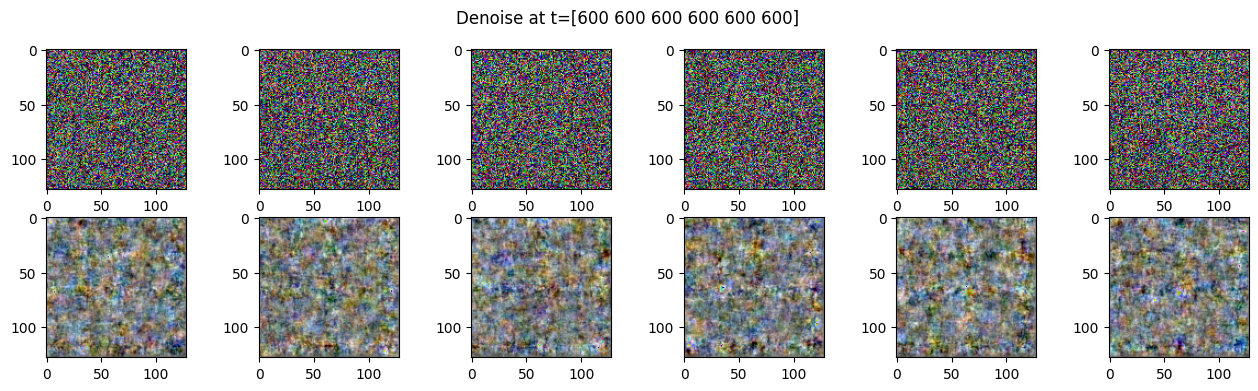

In [32]:
Val_iter = iter(dataVal)
X_test = dataVal.dataset.take(next(Val_iter)[0], A=True)#.to(trainer.loss_c.theta_device())
#X_test.requires_grad_(True)

cols = 6
#t = np.random.randint(50, 400, size=batch_size)
t = np.random.randint(600, 601, size=batch_size)
#X_noisy = trainer.noise_schedule.add_noise(X_test, t=t) #torch.randn_like(X_test).to(trainer.loss_c.theta_device())
# Add noise to create Y (noisy images)

noisy_images = []
for i, img in enumerate(X_test):
    noisy, _ = trainer.noise_schedule.add_noise(img.unsqueeze(0), t[i])
    noisy_images.append(noisy)
X_noisy = torch.cat(noisy_images, dim=0).to(trainer.loss_c.theta_device())
X_noisy.requires_grad_(True)

#Y_generated = trainer.denoise(X_noisy).detach().cpu()
Y_generated = trainer.progressive_denoise(X_noisy)[2].detach().cpu()

# Visualize
fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
fig.suptitle(f'Denoise at t={t}')

for i in range(cols):
    X_img = np.asarray(dataVal.dataset.to_image(X_noisy.detach().cpu())[i], dtype=np.uint8)
    _ = axes[0][i].imshow(X_img)

    Y_img = np.asarray(dataVal.dataset.to_image(Y_generated.cpu())[i], dtype=np.uint8)
    _ = axes[1][i].imshow(Y_img)

#plt.tight_layout()
fig.show()

In [12]:
trainer.loss_c.psi_theta.load_state_dict(torch.load("./psi_diff1_theta.pt"))
trainer.loss_c.psi_omega.load_state_dict(torch.load("./psi_diff1_omega.pt"))

<All keys matched successfully>

In [18]:
#torch.save(trainer.loss_c.psi_theta.state_dict(), "./psi_diff1_theta.pt")
#torch.save(trainer.loss_c.psi_omega.state_dict(), "./psi_diff1_omega.pt")